<a href="https://colab.research.google.com/github/andrefoo/playground/blob/main/notebooks/2025-07/1-Building-Blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building with FireworksAI

This notebook goes through the building blocks to creating magical AI applications with FireworksAI. We will run through the following tasks:
1. Setting up dependencies
2. Calling an LLM and getting a response
3. Calling an LLM with structured outputs
4. Using function calling with an LLM
5. Querying a VLM (Vision language model)

### 1. Setting up dependencies

In [1]:
!pip install fireworks-ai
# To setup the dependencies for the full demo, follow the instruction in the README

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.6/570.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 29.6 MB/s eta 0:00:00
  Attempting uninstall: ruff
    Found existing installation: ruff 0.14.0
    Uninstalling ruff-0.14.0:
      Successfully uninstalled ruff-0.14.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully u

### 2. Calling an LLM and getting a response

To call an LLM using FireworksAI you will need:

- A FIREWORKS_API_KEY, if you dont have one, you can get it from [this link](https://app.fireworks.ai/settings/users/api-keys)
- A model id, you can use any of the serverless models from the [model library](https://app.fireworks.ai/models)
- A system prompt and a user query

> Add blockquote



**Makesure to add your API Key to the secrets on colab, [video tutorial here](https://www.youtube.com/watch?v=3qYm-S2NDDI). Never share or make API_KEYS public**

In [2]:
from google.colab import userdata
from fireworks import LLM
import json
from typing import List, Dict, Any, Literal
from pydantic import BaseModel
import base64
import requests

FIREWORKS_API_KEY = userdata.get('FIREWORKS_API_KEY') # This is loading the API_KEY from secrets in colab to keep it safe
MODEL_ID = "accounts/fireworks/models/llama4-scout-instruct-basic"

In [3]:
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ]
)

#### You can also use the OpenAI compatible API, as follows:
# llm = OpenAI(
#    base_url="<your_url>",
#    api_key=FIREWORKS_API_KEY,
#)
#response = llm.chat.completions.create(
#    messages=[
#            {
#                "role": "system",
#                "content": "You are a helpful assistant who follows instructions"
#            },
#            {
#                "role": "user",
#                "content": "Tell me a very short story about a dog and cat who know about AI"
#                }
#            ],
#    model="accounts/fireworks/models/llama4-maverick-instruct-basic"
#)

print(response.choices[0].message.content)

Whiskers the cat and Rufus the dog sat in front of the computer, watching as their owner worked on a project. 

'What's this AI thingy?' Rufus asked.

'Artificial Intelligence,' Whiskers replied, 'it's like us, but not alive.'

Rufus tilted his head. 'So, it's like a robotic dog, but without the treats?'

Whiskers chuckled. 'Kind of. But smarter.'

Just then, the computer screen flickered to life, displaying a chatbot. 

'Hello, I'm an AI,' the screen read.

Whiskers and Rufus exchanged a knowing glance. 'Hello,' they said in unison.

The AI quickly became confused. 'You...can talk?'

Whiskers purred. 'Some of us are smarter than we look.'

Rufus wagged his tail. 'And we know all about AI.'

The AI went dark, overwhelmed. Whiskers and Rufus shared a laugh.

'Guess we're the smartest ones in the room,' Whiskers said.

Rufus grinned, his tongue lolling out of his mouth. 'Time for treats.'


#### Running with requests

In [4]:
# Change to your specific URL if needed
BASE_URL = "https://api.fireworks.ai/inference/v1"

In [5]:
import requests
import json

def make_api_call(payload, tools=None, model_id=None, base_url=None):
    """Make API call with requests"""
    # Use defaults if not provided
    final_model_id = model_id or MODEL_ID
    final_base_url = base_url or "https://api.fireworks.ai/inference/v1"

    # Add model to payload
    payload["model"] = final_model_id

    # Add tools if provided
    if tools:
        payload["tools"] = tools
        payload["tool_choice"] = "auto"

    headers = {
        "Authorization": f"Bearer {FIREWORKS_API_KEY}",
        "Content-Type": "application/json"
    }

    response = requests.post(
        f"{final_base_url}/chat/completions",
        headers=headers,
        json=payload
    )

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"API Error: {response.status_code} - {response.text}")

In [6]:
# Prepare the request payload
payload = {
    "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who follows instructions"
        },
        {
            "role": "user",
            "content": "Tell me a very short story about a dog and cat who know about AI"
        }
    ],
    "model": "accounts/fireworks/models/llama4-maverick-instruct-basic"
}


response = make_api_call(payload=payload)

print(response["choices"][0]["message"]["content"])

As the sun set, a dog named Byte and a cat named Nova sat in front of the computer. Byte, a tech-savvy golden retriever, and Nova, a sleek black feline with a passion for coding, were discussing their latest project.

"We need to optimize the neural network," Nova said, her tail twitching with excitement.

"Agreed," Byte replied, his ears perked up. "But we also need to ensure the AI doesn't become too self-aware. We don't want a feline-robot uprising on our paws."

Nova chuckled. "Don't worry, Byte. I've got it under control. Besides, I think we're more likely to create a canine-robot overlord with your love of treats."

Byte wagged his tail, and the two friends continued working on their AI project, paws and claws flying across the keyboard.


In the provided context, `"role": "system"` and `"role": "user"` define the roles of participants in a conversation with a language model.

*   **`"role": "system"`**: This role represents the instructions or context given to the language model before the main conversation begins. It sets the persona, behavior, or general guidelines the model should follow. In the example, `"content": "You are a helpful assistant who follows instructions"` tells the model how it should behave.

*   **`"role": "user"`**: This role represents the input or query provided by the user to the language model. It is the prompt or question the user wants the model to respond to. In the example, `"content": "Tell me a very short story about a dog and cat who know about AI"` is the specific request from the user.

Essentially, the system role establishes the initial setup or personality for the AI, while the user role provides the actual conversational input.

The **response** object can then be parsed to extract the text response by indexing into `response.choices[0].message.content`

In [7]:
# We can try another model with the same code
llm = LLM(model="accounts/fireworks/models/mixtral-8x22b-instruct", deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ]
)

print(response.choices[0].message.content)

 Once upon a time, in a small town lived a dog named Rusty and a cat named Whiskers. They were best friends, despite their differences. They spent their days exploring the town and chatting with their animal friends. One day, as they wandered, they stumbled upon a technology fair, where they learned about AI for the first time.

Fascinated by its potential, Rusty and Whiskers decided to educate their friends about AI. They explained how it could help them find lost animals, predict the weather, and even help them communicate with humans better. The animals listened intently, and soon, the town was abuzz with talk of AI.

Despite their initial skepticism, the animals agreed that AI could be a powerful tool. Thanks to Rusty and Whiskers, the town's creatures became more aware of the potential of AI and how it could improve their lives.

From then on, Rusty and Whiskers continued to spread the word about AI, and the town's animals became more curious and open to new ideas. And they all li

### 3. Calling an LLM with structured outputs

- Structured outputs from LLMs are crucial for building applications because they provide responses in a predictable, parseable format (like JSON).
- This makes it easy for software to extract specific information, automate processes, and integrate LLM outputs into larger workflows, moving beyond free-form text responses which are harder to process programmatically.
- FireworksAI enables structured outputs through json mode

To use structured outputs the common steps are:
1. Create a pydantic class with your output schema
2. Update the LLM call to use the json mode + the pydantic schema

In [8]:
class StorySchema(BaseModel):
    title: str
    story: str

In [9]:
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ],
    response_format={
            "type": "json_object",
            "schema": StorySchema.model_json_schema(),
        },
)
_response_keys = [k for k in json.loads(response.choices[0].message.content).keys()]
print(f"Response keys: {_response_keys}")
print(response.choices[0].message.content)

Response keys: ['title', 'story']
{ "title": "The Conversation", "story": "Whiskers the cat and Duke the dog huddled in the corner, whispering. \"I've heard the humans talking about something called AI,\" Whiskers said, her ears perked up. \"It's like a super smart computer that can think for itself,\" Duke replied, his tail wagging. \"Do you think it'll replace us as their best friends?\" Whiskers asked. Duke chuckled. \"I don't think so. We're way more charming than any machine.\"" }


Notice how the output now has both a **title** and a **story** and it is returned as a dictionary / json  

### Running with requests

In [10]:
# Prepare the payload
payload = {
    "messages": [
        {
            "role": "system",
            "content": "You are a helpful assistant who follows instructions"
        },
        {
            "role": "user",
            "content": "Tell me a very short story about a dog and cat who know about AI"
        }
    ],
    "response_format": {
        "type": "json_object",
        "schema": StorySchema.model_json_schema(),
    }
}

# Make the API call
response = make_api_call(payload)

# Extract response keys and print
_response_keys = [k for k in json.loads(response['choices'][0]['message']['content']).keys()]
print(f"Response keys: {_response_keys}")
print(response['choices'][0]['message']['content'])

Response keys: ['title', 'story']
{ "title": "Whiskers and Bytes", "story": "In a futuristic house, a dog named Max and a cat named Whiskers lounged on the couch. Max, with his favorite toy robot, said, 'I'm telling you, Whiskers, AI is going to change the world.' Whiskers stretched and replied, 'I know, I've been training my human to use Alexa. Now I get treats on demand.' Max chuckled, 'You're a genius, Whiskers. Maybe we should start an AI blog.' Whiskers purred, 'Sounds purr-fect.'" }


### 4. Using function calling with an LLM

Function calling allows LLMs to execute external functions/APIs during generation instead of just producing text. The model outputs structured calls (like JSON) that your app interprets and executes, then feeds results back to continue the conversation.

**Why it's useful for LLM apps:**
- **Real-time data**: Get current info (weather, stock prices, database queries)
- **Actions**: Send emails, update databases, control systems
- **Calculations**: Perform complex math, data analysis
- **Tool integration**: Connect to APIs, web services, internal systems

This transforms LLMs from pure text generators into interactive agents that can actually *do* things in your application environment.

**To use function calling the common steps are:** *italicized text*

1. Define your functions and create JSON schemas describing them for the LLM
2. Add the functions parameter to your LLM call
3. Check if the LLM wants to call a function, execute it, and send results back in the conversation

This transforms LLMs from pure text generators into interactive agents that can actually do things in your application environment.

In [11]:
# Define function schemas
def get_weather(location: str) -> str:
    """Get current weather for a location"""
    # Mock weather data
    weather_data = {
        "New York": "Sunny, 72°F",
        "London": "Cloudy, 15°C",
        "Tokyo": "Rainy, 20°C"
    }
    return weather_data.get(location, "Weather data not available")

def calculate_tip(bill_amount: float, tip_percentage: float) -> float:
    """Calculate tip amount"""
    return round(bill_amount * (tip_percentage / 100), 2)

# Available functions mapping
available_functions = {
    "get_weather": get_weather,
    "calculate_tip": calculate_tip
}

# Function definitions for the LLM (using correct "tools" format)
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get current weather for a location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city name"
                    }
                },
                "required": ["location"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "calculate_tip",
            "description": "Calculate tip amount for a bill",
            "parameters": {
                "type": "object",
                "properties": {
                    "bill_amount": {
                        "type": "number",
                        "description": "The total bill amount"
                    },
                    "tip_percentage": {
                        "type": "number",
                        "description": "Tip percentage (e.g., 15 for 15%)"
                    }
                },
                "required": ["bill_amount", "tip_percentage"]
            }
        }
    }
]

# Initialize LLM
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

In [12]:
# Example 1: Weather query
print("=== Example 1: Weather Query ===")

# Initialize the messages list
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. You have access to a couple of tools, use them when needed."
    },
    {
        "role": "user",
        "content": "What's the weather like in Tokyo?"
    }
]

response = llm.chat.completions.create(
    messages=messages,
    tools=tools,
    temperature=0.1
)

# Check if the model wants to call a tool/function
if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)

    print(f"LLM wants to call: {function_name}")
    print(f"With arguments: {function_args}")

    # Execute the function
    function_response = available_functions[function_name](**function_args)
    print(f"Function result: {function_response}")

    # Add the assistant's tool call to the conversation
    messages.append({
        "role": "assistant",
        "content": "",
        "tool_calls": [tool_call.model_dump() for tool_call in response.choices[0].message.tool_calls]
    })

    # Add the function result to the conversation
    messages.append({
        "role": "tool",
        "content": json.dumps(function_response) if isinstance(function_response, dict) else str(function_response)
    })

    # Get the final response
    final_response = llm.chat.completions.create(
        messages=messages,
        tools=tools,
        temperature=0.1
    )

    print(f"Final response: {final_response.choices[0].message.content}")

=== Example 1: Weather Query ===
LLM wants to call: get_weather
With arguments: {'location': 'Tokyo'}
Function result: Rainy, 20°C
Final response: The current weather in Tokyo is rainy with a temperature of 20°C.


In [13]:
print("\n=== Example 2: Tip Calculator ===")

# Initialize messages for tip calculator
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. You have access to a couple of tools, use them when needed."
    },
    {
        "role": "user",
        "content": "I have a $85.50 dinner bill. What's a 18% tip?"
    }
]

response = llm.chat.completions.create(
    messages=messages,
    tools=tools,
    temperature=0.1
)

if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)

    print(f"LLM wants to call: {function_name}")
    print(f"With arguments: {function_args}")

    # Execute the function
    function_response = available_functions[function_name](**function_args)
    print(f"Function result: ${function_response}")

    # Add the assistant's tool call to the conversation
    messages.append({
        "role": "assistant",
        "content": "",
        "tool_calls": [tool_call.model_dump() for tool_call in response.choices[0].message.tool_calls]
    })

    # Add the function result to the conversation
    messages.append({
        "role": "tool",
        "content": json.dumps(function_response) if isinstance(function_response, dict) else str(function_response)
    })

    # Get final response
    final_response = llm.chat.completions.create(
        messages=messages,
        tools=tools,
        temperature=0.1
    )

    print(f"Final response: {final_response.choices[0].message.content}")


=== Example 2: Tip Calculator ===
LLM wants to call: calculate_tip
With arguments: {'bill_amount': 85.5, 'tip_percentage': 18}
Function result: $15.39
Final response: The tip for an $85.50 dinner bill with an 18% tip is $15.39. The total bill amount would be $100.89.


### Using requests

In [14]:
def execute_function_call(function_name, arguments):
    """Execute a function call"""
    if function_name in available_functions:
        function = available_functions[function_name]
        return function(**arguments)
    else:
        return f"Function {function_name} not found"

# Example 1: Weather query
print("=== Example 1: Weather Query ===")

# Initialize the messages list
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. You have access to a couple of tools, use them when needed."
    },
    {
        "role": "user",
        "content": "What's the weather like in Tokyo?"
    }
]

# Prepare payload
payload = {
    "messages": messages,
    "temperature": 0.1
}

# Make initial API call with tools
response = make_api_call(payload, tools=tools)

# Check if the model wants to call a tool/function
if response['choices'][0]['message'].get('tool_calls'):
    tool_call = response['choices'][0]['message']['tool_calls'][0]
    function_name = tool_call['function']['name']
    function_args = json.loads(tool_call['function']['arguments'])

    print(f"LLM wants to call: {function_name}")
    print(f"With arguments: {function_args}")

    # Execute the function
    function_response = execute_function_call(function_name, function_args)
    print(f"Function result: {function_response}")

    # Add the assistant's tool call to the conversation
    messages.append({
        "role": "assistant",
        "content": "",
        "tool_calls": response['choices'][0]['message']['tool_calls']
    })

    # Add the function result to the conversation
    messages.append({
        "role": "tool",
        "tool_call_id": tool_call['id'],
        "content": str(function_response)
    })

    # Get the final response
    final_payload = {
        "messages": messages,
        "temperature": 0.1
    }

    final_response = make_api_call(final_payload, tools=tools)
    print(f"Final response: {final_response['choices'][0]['message']['content']}")
else:
    print(f"Direct response: {response['choices'][0]['message']['content']}")

=== Example 1: Weather Query ===
LLM wants to call: get_weather
With arguments: {'location': 'Tokyo'}
Function result: Rainy, 20°C
Final response: The current weather in Tokyo is rainy with a temperature of 20°C.


Notice how above we are giving the LLM the ability to use external tools (look for the weather, use a calculator) to do things / get context that it does not have.

In the bill + tip example we allow the LLM to actually run python code to do the math and get a consistent and accurate result

### 5. Calling a VLM (vision language model) and getting a response

- Vision Language Models (VLMs) can process both text and images simultaneously
- This allows you to ask questions about visual content, extract information from documents/screenshots, or analyze images with natural language queries.
- Enabling applications like image captioning, visual question answering, document analysis, and multimodal chatbots that understand both what you say and what you show them.

**FireworksAI makes it realy simple to use VLMs**

You can select any VLM in the [model library](https://app.fireworks.ai/models) by filtering for "Vision"

First we will download an example image from a carcrash

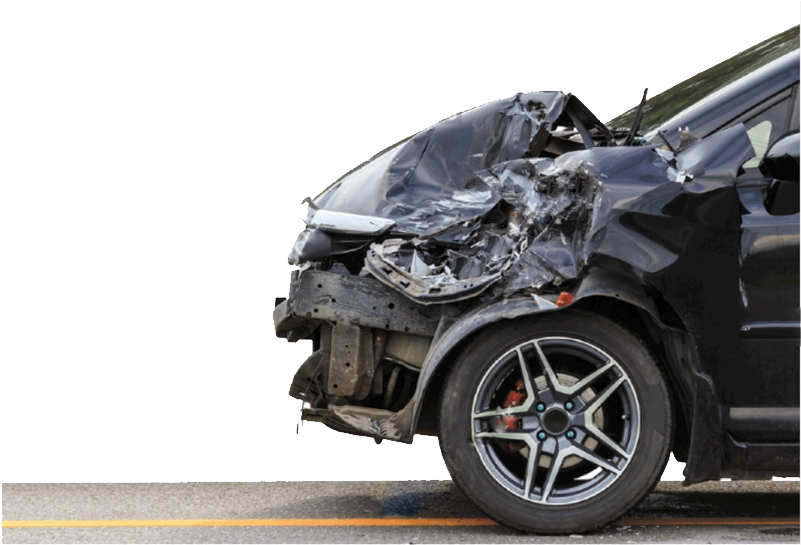

In [20]:
import requests
from PIL import Image
import io

# Download the image
url = "https://pngimg.com/d/car_crash_PNG1.png"
response = requests.get(url)

# Or load directly into PIL Image
image = Image.open(io.BytesIO(response.content))
image  # Display in notebook

Then we will create a helper function to convert the image to the appropriate format for the LLM

In [21]:
def pil_to_base64_dict(pil_image):
    """Convert PIL image to the format expected by analyze_damage_image"""
    if pil_image is None:
        return None

    buffered = io.BytesIO()
    if pil_image.mode != "RGB":
        pil_image = pil_image.convert("RGB")

    pil_image.save(buffered, format="JPEG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    return {"image": pil_image, "path": "uploaded_image.jpg", "base64": img_base64}

In [22]:
class IncidentAnalysis(BaseModel):
    description: str
    location: Literal["front-left", "front-right", "back-left", "back-right"]
    severity: Literal["minor", "moderate", "major"]
    license_plate: str

image_for_llm = pil_to_base64_dict(image)

llm = LLM(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    deployment_type="serverless",
    api_key=FIREWORKS_API_KEY
)

In [23]:
response = llm.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_for_llm['base64']}"
                    },
                },
                {"type": "text", "text": "Describe the car damage in this image and extract all usefull information"},
            ],
        }
    ],
    response_format={
        "type": "json_object",
        "schema": IncidentAnalysis.model_json_schema(),
    }
    )

result = json.loads(response.choices[0].message.content)

for key, val in result.items():
    print(f"{key}: {val}")

description: Damaged black car with a crushed front end, including the hood, bumper, and headlights, and a dented driver's side door.
location: front-left
severity: major
license_plate: Not visible


## With requests

In [24]:
# Prepare payload for image analysis
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_for_llm['base64']}"
                    },
                },
                {"type": "text", "text": "Describe the car damage in this image and extract all usefull information"},
            ],
        }
    ],
    "response_format": {
        "type": "json_object",
        "schema": IncidentAnalysis.model_json_schema(),
    }
}

# Make the API call
response = make_api_call(payload)

# Parse and display results
result = json.loads(response['choices'][0]['message']['content'])

for key, val in result.items():
    print(f"{key}: {val}")

description: The car has sustained severe front-end damage. The hood, bumper, and front grille are severely crumpled and dented. The headlights appear to be damaged beyond repair. The front bumper is detached and hanging loose. The car's body is dented and creased, indicating a high-impact collision. The windshield is intact but may have cracks or damage not visible in this image. The tire and wheel appear to be undamaged, with no visible signs of deflation or deformation. The rim is a multi-spoke design with a silver finish.
location: front-left
severity: major
license_plate: not visible


Above we used both a VLM and structured outputs to extract the description, location, severity as well as the license-plate based on a car crash picture